### Setup for path variable to connect to DB

In [1]:
import sys
import os

_path_added = False

def add_project_root_to_path():
    """
    Check if the project root directory is in the Python path.
    If not, add it to sys.path and change the working directory to the project root.
    """
    global _path_added

    if _path_added:
        return
    
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

    if root_dir not in sys.path:
        sys.path.append(root_dir)
        print(f"Added {root_dir} to Python path.")
    
    if os.getcwd() != root_dir:
        os.chdir(root_dir)
        print(f"Changed working directory to {root_dir}.")
    _path_added = True


add_project_root_to_path()

Added /home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping to Python path.
Changed working directory to /home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping.


### Setup connection and session to SQLite DB

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from dorfterror_database.database_structure import Base, Post, Profile
from pathlib import Path

root_path = Path(".").resolve()
print(root_path)

engine = create_engine(f"sqlite:///{root_path}/dorfterror_database/dorfterror.db")
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

/home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping


### Get Posts from DB

In [15]:
total_posts = session.query(Post).count()

# Top 25% erfolgreichste Posts
top_posts = (
    session.query(Post)
    .order_by(Post.like_count.desc())
    #.limit( int(total_posts * 0.25) )
    .all()
)

print(top_posts)
print(f"Anzahl der Posts: {len(top_posts)}")

[<dorfterror_database.database_structure.Post object at 0x7a4052fb76b0>, <dorfterror_database.database_structure.Post object at 0x7a4051e08bf0>, <dorfterror_database.database_structure.Post object at 0x7a4052fb6f90>, <dorfterror_database.database_structure.Post object at 0x7a4052fb6f30>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7110>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7e00>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7d40>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7860>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7b90>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7320>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7530>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7170>, <dorfterror_database.database_structure.Post object at 0x7a4052fb7710>, <dorfterror_database.database_structure.Post object at 0x7a4052

### Setup Client to LM Studio

In [5]:
from openai import OpenAI

# Initialize LM Studio client
client = OpenAI(base_url="http://192.168.178.85:1200/v1", api_key="lm-studio")
MODEL = "google/gemma-3-12b"


#### Function for asking the LLM to categorize the Posts

In [19]:
def get_categories(post):
    """
    Get categories for a post using the LM Studio client.
    """
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {
                "role": "system",
                "content": "Du bist eine Expertin darin, Instagram-Posts anhand ihres Inhalts zu kategorisieren. Diese Kategorien kannst du verwenden: „Musikalische Aktivität & Releases“, „Live-Musik & Tournee“, „Bandmitglieder & Team“, „Werte & Haltung“, „Merchandise“.",
            },
            {
                "role": "user",
                "content": f"Es darf nur eine Kategorie verwendet werden und gib keine Begründung an, sondern nur eine Kategorie. Kategorisiere den folgenden Post: {post.caption}",
            },
        ],
        max_tokens=100,
    )
    
    categories = response.choices[0].message.content.strip()
    return categories

In [20]:
post_categories = {}

for post in top_posts:
    categories = get_categories(post)
    post_categories[post.id] = categories
    print(f"Post ID: {post.id}, Categories: {categories}")

Post ID: 3558420190388657708, Categories: Werte & Haltung
Post ID: 3354615879621148269, Categories: Musikalische Aktivität & Releases
Post ID: 3484304186725799873, Categories: Bandmitglieder & Team
Post ID: 3525759813989560877, Categories: Live-Musik & Tournee
Post ID: 3424317889374594372, Categories: Bandmitglieder & Team
Post ID: 3428018308341265565, Categories: Bandmitglieder & Team
Post ID: 2952710126750917334, Categories: Werte & Haltung
Post ID: 3525022422026697191, Categories: Bandmitglieder & Team
Post ID: 1919143627777337548, Categories: Musikalische Aktivität & Releases
Post ID: 3615709126985800120, Categories: Musikalische Aktivität & Releases
Post ID: 3497598025804652983, Categories: Werte & Haltung
Post ID: 3014228045728590247, Categories: Musikalische Aktivität & Releases
Post ID: 3150250238614587108, Categories: Live-Musik & Tournee
Post ID: 3488011984697305274, Categories: Bandmitglieder & Team
Post ID: 3629492663649259897, Categories: Live-Musik & Tournee
Post ID: 3411

### Check categories, group by categories to get likes and proportion of Likes and Postcount

In [27]:
import pandas as pd

print(post_categories)
print(top_posts)

rows = []

for post in top_posts:
    rows.append({
        'id': post.id,
        'caption': post.caption,
        'like_count': post.like_count,
        'comment_count': post.comment_count
    })

post_df = pd.DataFrame(rows)

post_df['categories'] = post_df['id'].map(post_categories)

display(post_df)

{'3558420190388657708': 'Werte & Haltung', '3354615879621148269': 'Musikalische Aktivität & Releases', '3484304186725799873': 'Bandmitglieder & Team', '3525759813989560877': 'Live-Musik & Tournee', '3424317889374594372': 'Bandmitglieder & Team', '3428018308341265565': 'Bandmitglieder & Team', '2952710126750917334': 'Werte & Haltung', '3525022422026697191': 'Bandmitglieder & Team', '1919143627777337548': 'Musikalische Aktivität & Releases', '3615709126985800120': 'Musikalische Aktivität & Releases', '3497598025804652983': 'Werte & Haltung', '3014228045728590247': 'Musikalische Aktivität & Releases', '3150250238614587108': 'Live-Musik & Tournee', '3488011984697305274': 'Bandmitglieder & Team', '3629492663649259897': 'Live-Musik & Tournee', '3411332673173632846': 'Merchandise', '3387475397195123646': 'Werte & Haltung', '3447628255509007412': 'Live-Musik & Tournee', '3443221890643457929': 'Live-Musik & Tournee', '3453215750590019655': 'Live-Musik & Tournee', '3535250485381690792': 'Live-Mu

,id,caption,like_count,comment_count,categories
0,3558420190388657708,Milljiune Leit in Trier bei der Demo „Wir sind...,2033.0,39,Werte & Haltung
1,3354615879621148269,Ihr herzallerliebsten KnöpfchenDrückerInnen! U...,600.0,13,Musikalische Aktivität & Releases
2,3484304186725799873,"Hallo und schön, dass du uns gefunden hast 🥰 W...",516.0,14,Bandmitglieder & Team
3,3525759813989560877,Wir haben da noch ein kleines Throwback-Reel f...,441.0,11,Live-Musik & Tournee
4,3424317889374594372,"Hey Leute! 🎸\nIch bin Chili / Julia, die neue ...",441.0,19,Bandmitglieder & Team
...,...,...,...,...,...
557,3395363676308439573,Einerseits sind diese Social Media-Zahlenspiel...,NaN,0,Werte & Haltung
558,3393741293215746034,"Open Air im Sommer vor einem Schloss, freier E...",NaN,1,Werte & Haltung
559,3391884787553816953,Was ein geiles Wochenende! Vielen Dank an alle...,NaN,2,Live-Musik & Tournee
560,3388135884521110642,Freitag geht's weiter beim Jugend-Kultur Festi...,NaN,2,Live-Musik & Tournee


In [38]:
summary = post_df.groupby('categories').agg(
    total_likes=('like_count', 'sum'),
    post_count=('id', 'count')
).reset_index()

# Gesamtwerte berechnen
total_posts = summary['post_count'].sum()
total_likes = summary['total_likes'].sum()

# Prozent-Spalten hinzufügen
summary['percent_posts'] = (summary['post_count'] / total_posts * 100).round(2)
summary['percent_likes'] = (summary['total_likes'] / total_likes * 100).round(2)

display(summary)

,categories,total_likes,post_count,percent_posts,percent_likes
0,Bandmitglieder & Team,5575.0,35,6.23,8.57
1,Live-Musik & Tournee,26005.0,242,43.06,39.98
2,Merchandise,2710.0,26,4.63,4.17
3,Musikalische Aktivität & Releases,15060.0,138,24.56,23.15
4,Werte & Haltung,15701.0,121,21.53,24.14


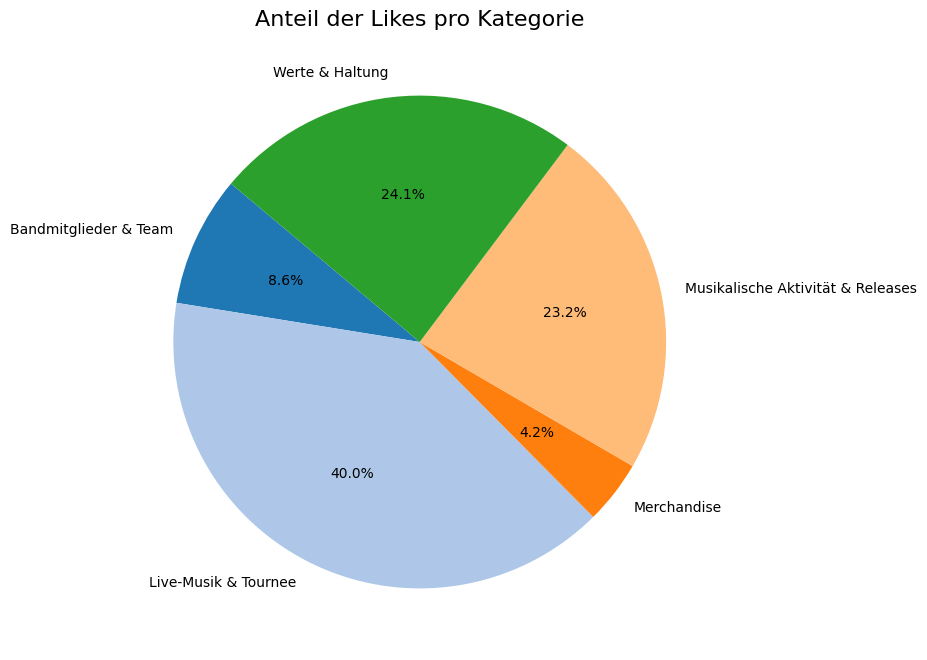

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gruppiere Likes pro Kategorie
likes_per_category = post_df.groupby('categories')['like_count'].sum().reset_index()

# Erzeuge eine Farbpalette mit so vielen Farben wie Kategorien
colors = plt.cm.tab20.colors[:len(likes_per_category)]  # tab20 hat 20 verschiedene Farben

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    likes_per_category['like_count'],
    labels=likes_per_category['categories'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors  # verschiedene Farben
)
plt.title('Anteil der Likes pro Kategorie', fontsize=16)
plt.show()


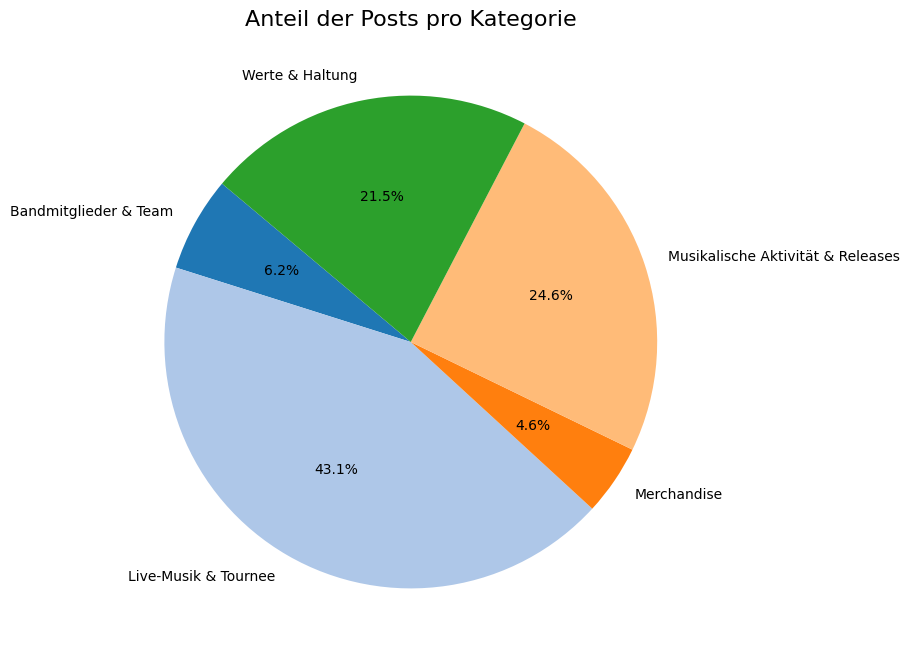

In [40]:
import matplotlib.pyplot as plt

# Erzeuge eine Farbpalette
colors = plt.cm.tab20.colors[:len(summary)]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    summary['post_count'],
    labels=summary['categories'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title('Anteil der Posts pro Kategorie', fontsize=16)
plt.show()


In [24]:
def prepare_weighted_captions(posts):
    """
    Bereitet die Captions mit Gewichtung basierend auf Like-Anteil vor.
    """
    # Gesamtsumme der Likes berechnen
    total_likes = sum(post.like_count for post in posts if post.like_count)
    if total_likes == 0:
        raise ValueError("Keine Likes gefunden – überprüfe die Daten.")

    # Berechne Gewicht für jede Caption
    weighted_captions = []
    for post in posts:
        if post.caption and post.like_count:
            weight = post.like_count / total_likes
            # Multipliziere die Caption proportional (Skalierungsfaktor 10 für mehr Wirkung)
            repeats = int(weight * 10 * len(posts))  # z.B. bei 5% Gewicht ≈ 2-3 Wiederholungen
            weighted_captions.extend([post.caption] * max(1, repeats))
    
    return weighted_captions

def chunk_list(data, chunk_size):
    """Teile die Liste in kleinere Chunks auf."""
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]


In [29]:

def analyze_style_and_content(weighted_captions, chunk_size=100, model=MODEL):
    """
    Lässt das Modell Schreibstil, Tonfall, Themen und Hashtags analysieren.
    """
    combined_analysis = []

    for chunk in chunk_list(weighted_captions, chunk_size):
        # Alle gewichteten Captions zusammenführen
        joined_captions = "\n".join([f"- {caption}" for caption in chunk])

        # Prompt zur Analyse
        prompt = (
            "Du bist ein Social Media Experte für eine Band. Analysiere die folgenden Instagram-Captions "
            "und beschreibe ausführlich:\n"
            "1. Den Schreibstil (z.B. locker, emotional, witzig)\n"
            "2. Den typischen Tonfall (z.B. motivierend, humorvoll)\n"
            "3. Häufig verwendete Wörter oder Phrasen\n"
            "4. Beliebte Themen in den Posts\n"
            "5. Häufig genutzte Emojis und Hashtags\n\n"
            "Hier sind die Captions (mehrfach wiederholt, je nach Wichtigkeit):\n"
            "---\n"
            f"{joined_captions}\n"
            "---\n\n"
            "Gib deine Analyse als strukturierte Liste aus."
        )

        # Anfrage an LM Studio
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=800,
            timeout=60
        )

        analysis = response.choices[0].message.content.strip()
        print(f"📦 Analyse für Chunk {idx}:\n{analysis}\n{'-'*50}\n")
        combined_analysis.append(analysis)
    
    return "\n".join(combined_analysis)


def generate_new_caption(style_analysis, new_context, model=MODEL):
    """
    Nutzt die Stil-Analyse und den neuen Kontext, um neue Captions zu generieren.
    """
    prompt = (
        "Basierend auf der folgenden Analyse des Schreibstils und der Inhalte unserer bisherigen Instagram-Posts:\n\n"
        f"{style_analysis}\n\n"
        "Wir möchten einen neuen Post veröffentlichen mit folgendem Kontext:\n"
        f"{new_context}\n\n"
        "💡 Erstelle 3 kreative Instagram-Captions, die den beschriebenen Stil und Tonfall übernehmen, "
        "die beliebten Themen und Hashtags einbeziehen und maximal 2 Sätze lang sind. "
        "Verwende Emojis passend zum Inhalt und füge bis zu 3 Hashtags hinzu. Gib die Captions als nummerierte Liste aus."
    )

    # Anfrage an LM Studio
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.95,
        max_tokens=500
    )

    return response.choices[0].message.content.strip()


In [30]:
# --- 🔥 Anwendung ---
# 1. Alle Posts aus DB
#all_posts = session.query(Post).filter(Post.caption.isnot(None)).all()
all_posts = top_posts

# 2. Gewichtete Captions vorbereiten
weighted_captions = prepare_weighted_captions(all_posts)

# 3. Schreibstil und Inhalte analysieren
style_analysis = analyze_style_and_content(weighted_captions)

print("📊 Analyse des Schreibstils und der Inhalte:\n")
print(style_analysis)

# 4. Neue Caption generieren
new_context = "Wir haben gerade ein Konzert auf dem Dalmstöckle Open Air gespielt und möchten dazu Bilder posten."
new_captions = generate_new_caption(style_analysis, new_context)

print("\n✨ Vorschläge für neue Captions:\n")
print(new_captions)

APITimeoutError: Request timed out.

In [ ]:
# Funktion: Extrahiere Themen aus Captions
def get_themes_from_captions(captions_block):
    joined_captions = "\n".join([f"- {c}" for c in captions_block])

    prompt = (
        "Die folgenden Instagram-Captions stammen von sehr erfolgreichen Posts. "
        "Analysiere diese Captions und liste die Hauptthemen auf, die sie gemeinsam haben. "
        "Fasse ähnliche Themen zusammen und gib sie als nummerierte Liste aus.\n\n"
        f"{joined_captions}"
    )

    # Anfrage an LM Studio senden
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "Du bist ein Social-Media-Analyst."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.5,
        max_tokens=500
    )

    # Antwort zurückgeben
    return response.choices[0].message.content

In [9]:
def chunk_list(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

caption_chunks = list(chunk_list(captions, 5))  # z.B. 5 Captions pro Chunk

all_themes = []
for i, block in enumerate(caption_chunks):
    print(f"\n📝 Block {i + 1} Themen:")
    themes = get_themes_from_captions(block)
    print(themes)
    all_themes.append(themes)

# Optional: Alle Themen aus allen Chunks zusammenfassen
print("\n\n=== Zusammenfassung aller Themen aus allen Chunks ===")
print("\n".join(all_themes))


📝 Block 1 Themen:
Okay, hier ist eine Analyse der Instagram-Captions von Dorfterror, die auf die Hauptthemen fokussiert ist und diese zusammenfasst:

**Hauptthemen & Zusammenfassungen:**

1.  **Musikalische Aktivität & Releases:** Dies ist das dominierendste Thema. Die Band stellt regelmäßig neue Musik (EPs, Musikvideos) vor und teilt Streaming-Links. Es geht um die aktive Verbreitung ihrer Musik.
2.  **Live-Musik & Tournee:** Dorfterror legt großen Wert auf Live-Auftritte. Sie teilen regelmäßig Konzerttermine, Ankündigungen für Festivals und eigene Shows. Die Band betont das gemeinsame Musizieren und die Bühnenpräsenz.
3.  **Community & Fan Engagement:** Ein zentraler Punkt ist der Aufbau einer starken Community. Dies wird durch direkte Ansprache (“Ihr herzallerliebsten KnöpfchenDrückerInnen!”), Dankesbotschaften an Fans, Aufforderungen zum Teilen und Konsumieren (im Sinne von Musik hören/kaufen) sowie die Einbindung in Diskussionen (z.B. “Rock gegen Rechts”) erreicht.
4.  **Bandmitg

In [13]:
def generate_caption_with_style(captions, new_context, themes, model=MODEL):
    # Füge alle Captions zusammen (achte auf Token-Limit)
    joined_captions = "\n".join([f"- {caption}" for caption in captions[:10]])  # Nimm z.B. nur die ersten 20, um Token zu sparen

    # Erstelle Themen-Text
    themes_text = "\n".join([f"{i+1}. {theme}" for i, theme in enumerate(themes)])
    
    # Prompt mit Schreibstil + Themen + neuem Kontext
    prompt = (
        "Du bist Social Media Experte für eine Band. Analysiere zunächst den Schreibstil der folgenden Instagram-Captions "
        "und verwende diesen Stil für neue Vorschläge.\n\n"
        "Hier sind einige unserer erfolgreichsten Captions:\n"
        "---\n"
        f"{joined_captions}\n"
        "---\n\n"
        "Die folgenden Themen waren in unseren Posts besonders erfolgreich:\n"
        f"{themes_text}\n\n"
        "Wir möchten Fotos von folgendem Ereignis posten:\n"
        f"{new_context}\n\n"
        "💡 Schreibe 3 kreative Instagram-Captions, die:\n"
        "- Den Schreibstil aus den Beispielen oben übernehmen\n"
        "- Die erfolgreichen Themen aufgreifen\n"
        "- Emotional, mitreißend und passend für den Instagram-Auftritt einer Band sind\n"
        "- Emojis und bis zu 3 relevante Hashtags enthalten\n"
        "- Maximal 1–2 Sätze lang sind\n\n"
        "Gib die Captions als nummerierte Liste aus."
    )

    # Anfrage an LM Studio
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.95,  # Etwas kreativer
        max_tokens=500
    )
    
    return response.choices[0].message.content.strip()


# Beispiel-Daten
new_context = "Wir haben gerade ein Konzert auf dem Dalmstöckle Open Air gespielt und möchten dazu Bilder posten."
themes_for_creation = all_themes

print(themes_for_creation)

#captions = [post.caption for post in top_posts]  # Deine bestehenden Captions aus DB-Abfrage

# Aufruf
result = generate_caption_with_style(captions, new_context, themes_for_creation)
print("✨ Vorschläge für neue Captions:\n")
print(result)



['Okay, hier ist eine Analyse der Instagram-Captions von Dorfterror, die auf die Hauptthemen fokussiert ist und diese zusammenfasst:\n\n**Hauptthemen & Zusammenfassungen:**\n\n1.  **Musikalische Aktivität & Releases:** Dies ist das dominierendste Thema. Die Band stellt regelmäßig neue Musik (EPs, Musikvideos) vor und teilt Streaming-Links. Es geht um die aktive Verbreitung ihrer Musik.\n2.  **Live-Musik & Tournee:** Dorfterror legt großen Wert auf Live-Auftritte. Sie teilen regelmäßig Konzerttermine, Ankündigungen für Festivals und eigene Shows. Die Band betont das gemeinsame Musizieren und die Bühnenpräsenz.\n3.  **Community & Fan Engagement:** Ein zentraler Punkt ist der Aufbau einer starken Community. Dies wird durch direkte Ansprache (“Ihr herzallerliebsten KnöpfchenDrückerInnen!”), Dankesbotschaften an Fans, Aufforderungen zum Teilen und Konsumieren (im Sinne von Musik hören/kaufen) sowie die Einbindung in Diskussionen (z.B. “Rock gegen Rechts”) erreicht.\n4.  **Bandmitglieder & T

BadRequestError: Error code: 400 - {'error': 'Trying to keep the first 7495 tokens when context the overflows. However, the model is loaded with context length of only 4096 tokens, which is not enough. Try to load the model with a larger context length, or provide a shorter input'}